# Assignment 5 - General Adversariel Network (GAN) Monet Painting Style Transfer

## Description

This project is a GAN based style transformation. The goal of this project is to develop a GAN model that can accurately transfer the Monet style of paintings to a photograph. The model will train on sample Monet painting images learning the Monet style.  It will then reproduce photographs in the Monet style. The data is provided by  the Kaggle competition 'I'm Somewhat of a Painter Myself' Competition and located at https://www.kaggle.com/competitions/gan-getting-started.

CycleGAN a very popular extension of the GAN architecture will be used to develope the model.  CycleGan deploys two Generator and discriminator models to create the style transfer paramters. A more detailed description of the CyclGan architecture is provided in the Model section of the document.

GAN networks are a common tools employed in generative Artificial Intelligence. Generative AI uses deep learning techniques to produce or replicate new content, such as images, music, and text.  Generative models aim to generate outputs based on ittle or no related inputs.  They can work in a purely productive manner where no related inputs are provided or in a replecative manner where related inputs are provided to produce a desired output.  In the most simplistic terms, GAN networks can be thought of as a tug-o-war between the generative (generator) and descrimintive (descriminator) components of the network.

The generator produces an output based on some inputs.  The descriminator takes the output from the generator asinput.  The discriminator then makes an assessment of the generator's input as real of fake. The output of the discriminator is then fed back into both genrator and discriminator.  The discriminator attempts to fool the generator with feedback while also using its own feedback.  The two battle back and forth resulting in both improving their ability to produce and identify the most accurate outputs. 

The course material was a very brief and provided only a very high level view of GAN theory. The course material did not cover GAN implmentation.  With that in mind, this project will rely heavily on the tutorials in the references for implementation guidance.  Custom adaptations will be injected where possible to build a unique project structured around the tutorial's base structures.  The course did not offer specifics into the CycleGAN package.  For readability and consistency purposes, non-model elements in this project will be pulled from the tutorial where applicable.

## Data Summary


In [ ]:
#!pip 


In [3]:
#Set Page Width to 100%
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
#Load Required Resources
import os
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

import tensorflow as tf

#from Monet CycleGAN Tutorial
#Uncomment for use in Kaggle notebook
#from kaggle_datasets import KaggleDatasets
#import tensorflow_addons as tfa

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.10.1


**Build Dataset**

As loading the data set is beyond the scope of this project the 'Load in the Data' code provided in the Kaggel tutorial will be implemented.  

In [6]:
#Kaggle Notebook Data Import
#from Monet CycleGAN Tutorial
#Uncomment for use in KAggle notebook
# GCS_PATH = KaggleDatasets().get_gcs_path()

# monet_filename_id = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
# print('Count of Monet TF record Files:', len(monet_filename_id))

# photo_filename_id = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
# print('Count of Photo TF record Files: ', len(photo_filename_id))

In [8]:
# Local Data Import
# The .tfrec files from the Kaggle Competition site will be used
#Comment out for use in KAggle Notebook
monet_filename_id = tf.io.gfile.glob(str('monet_tfrec/*.tfrec'))
print('Count of Monet TF record Files: ', len(monet_filename_id))

photo_filename_id = tf.io.gfile.glob(str('photo_tfrec/*.tfrec'))
print('Count of Photo TF record Files: ', len(photo_filename_id))

Count of Monet TF record Files:  5
Count of Photo TF record Files:  20


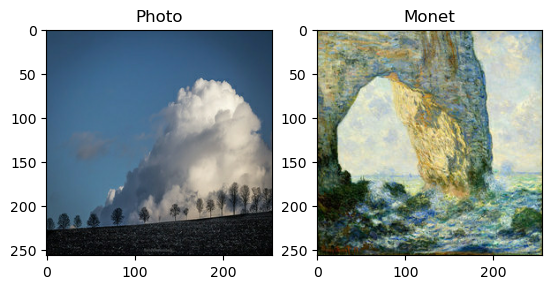

In [9]:
# Scale the images and pull only the image files
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

#Example and visualize scaled images

monet_ds = load_dataset(monet_filename_id, labeled=True).batch(1)
photo_ds = load_dataset(photo_filename_id, labeled=True).batch(1)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### EDA

EDA will be performed as follows:

    1. Verify Train Image Counts and Size
    2. Verify Test Image Counts and size
    3. Provide Sample Monet and photograh images

Various random images, and thier sizes were reviewed and the Monet images are assessed to be of the Monet style and photo images are photgraphs.  Given that the images and photos are directly from the competition dataset, and the dompetition dataset is assumed to be in the porper condition no addtional EDA is requied.

In [10]:
# Sample Images and sizes
monet_file_id_df = pd.DataFrame(monet_filename_id)
print('Monet File Summary:')
print(monet_file_id_df.head())
print(monet_file_id_df.info())

photo_file_id_df = pd.DataFrame(photo_filename_id)
print('Photo FileSummary:')
print(photo_file_id_df.head())
print(photo_file_id_df.info())

Monet File Summary:
                              0
0  monet_tfrec\monet00-60.tfrec
1  monet_tfrec\monet04-60.tfrec
2  monet_tfrec\monet08-60.tfrec
3  monet_tfrec\monet12-60.tfrec
4  monet_tfrec\monet16-60.tfrec
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5 non-null      object
dtypes: object(1)
memory usage: 168.0+ bytes
None
Photo FileSummary:
                               0
0  photo_tfrec\photo00-352.tfrec
1  photo_tfrec\photo01-352.tfrec
2  photo_tfrec\photo02-352.tfrec
3  photo_tfrec\photo03-352.tfrec
4  photo_tfrec\photo04-352.tfrec
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       20 non-null     object
dtypes: object(1)
memory usage: 288.0+ bytes
None


Monet Sample Image 1 Shape
(256, 256, 3)


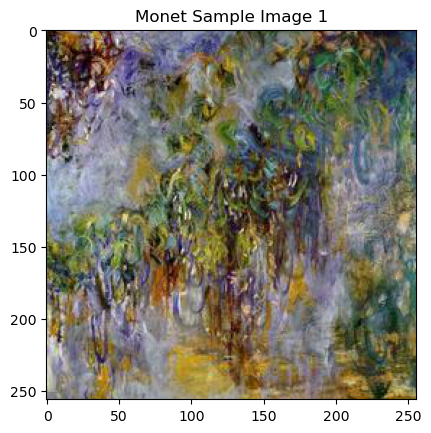

Monet Sample Image 2 Shape
(256, 256, 3)


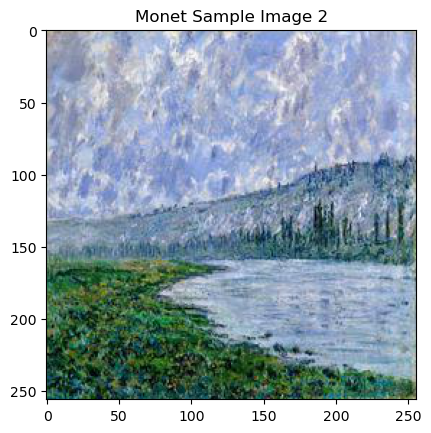

Photo Sample Image 1 Shape
(256, 256, 3)


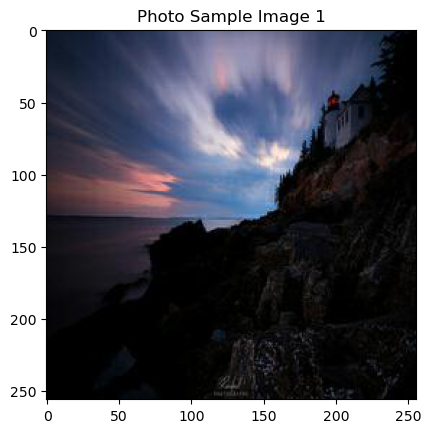

Photo Sample Image 2 Shape
(256, 256, 3)


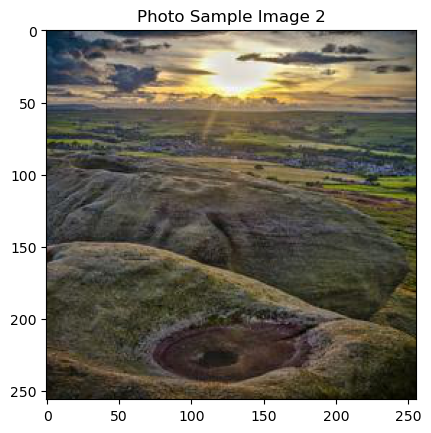

In [11]:
# Plot Example Images

monet1 = plt.imread('monet_jpg/0a5075d42a.jpg')
print('Monet Sample Image 1 Shape')
print(monet1.shape)
plt.imshow(monet1)
plt.title('Monet Sample Image 1')
plt.show()

monet2 = plt.imread('monet_jpg/0bd913dbc7.jpg')
print('Monet Sample Image 2 Shape')
print(monet2.shape)
plt.imshow(monet2)
plt.title('Monet Sample Image 2')
plt.show()

photo1 = plt.imread('photo_jpg/0a0c3a6d07.jpg')
print('Photo Sample Image 1 Shape')
print(photo1.shape)
plt.imshow(photo1)
plt.title('Photo Sample Image 1')
plt.show()

photo2 = plt.imread('photo_jpg/0a0d3e6ea7.jpg')
print('Photo Sample Image 2 Shape')
print(photo2.shape)
plt.imshow(photo2)
plt.title('Photo Sample Image 2')
plt.show()

In [ ]:
#Suppress Warning Messages Code
import warnings
warnings.filterwarnings('ignore')

### Models

The CycleGAN UNET architecture consists of two generators and two discriminators.  The first generator learns image 1 and translates image 1 to image 2.  The second generatore perfroms the inverse and learns image 2 and translates image 2 to image 1.  THE discriminators also cme in a pair.  The first discriminator learns how to differenciate between images 1 and the grenerated image 2.  The second discriminator, similiar to the second generator's role learns the inverse of discriminator 1 and learns how to differentiate between image2 and the gernerated image 1.

Based on a review of the literature a good trade off between processing time and accuracy is between 3-6 convolution layers in the generator and  discriminator.  For this project we'll split the difference and start with 4 layers of each.  For the upsampling (encoding) side the generator will have four convolution layers with a stride of 2 and the ReLU activation function.  For downsampling (decoding) the generator will have three transpose convolution layers with a stride of 2 and ReLU activation function.  The final encoding layer will use the tanh activation function.

For downsampling (decoding) the discriminator will have three transpose convolution layers with a stride of 2 and ReLU activation function.  The final encoding layer will use the tanh activation function.

The models will be constructed as follows
1. Build the generator and discrimnator, including both down sampleing and upsampling
2. Define the loss functions
3. Train the models



**Import the CycleGAN Class and loss Functions From Kaggle Tutorial**

In [12]:
# The CycleGAN class has been imported from the Kaggle Tutorial notebook
# link: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook#Build-the-generator

class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [2]:
with strategy.scope():
    
    
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss
#Alternate optimizers to be used for model comparison   

#     monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
#     photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#     monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
#     photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    monet_generator_optimizer = tf.keras.optimizers.SGD(learning_rate=.00001, momentum=.00001)
    photo_generator_optimizer = tf.keras.optimizers.SGD(learning_rate=.00001, momentum=0.00001)

    monet_discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=.00001, momentum=.00001)
    photo_discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=.00001, momentum=.00001)

NameError: name 'strategy' is not defined

**Define the generator and discriminator**

In [45]:
#Use this format for upsampleand down sample instaed od the def upsample/downsample from tutorial
#Monet who???


def generator():   

    input_shape = tf.keras.layers.Input(shape=[256, 256, 3])
    
    # Down Sampling (Encoder)
    downsample_layer_1 = tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(input_shape)
    downsample_layer_2 = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(downsample_layer_1)
    downsample_layer_3 = tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(downsample_layer_2)
    downsample_layer_4 = tf.keras.layers.Conv2D(512, (4, 4), strides=2, padding='same', activation='relu')(downsample_layer_3)
    
    # Up Sampling (Decoder)
    upsample_layer_1 = tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', activation='relu')(downsample_layer_4)
    upsample_layer_2 = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', activation='relu')(upsample_layer_1)
    upsample_layer_3 = tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', activation='relu')(upsample_layer_2)
    
    output = tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(upsample_layer_3)
    
    return tf.keras.Model(inputs=input_shape, outputs=output)


def discriminator():
    input_shape= tf.keras.layers.Input(shape=[256, 256, 3])
    
    dis_downsample_layer1 = tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(input_shape)
    dis_downsample_layer2 = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(dis_downsample_layer1)
    dis_downsample_layer3 = tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(dis_downsample_layer2)
    
    output = tf.keras.layers.Conv2D(1, (4, 4), padding='same')(dis_downsample_layer3)
    
    return tf.keras.Model(inputs=input_shape, outputs=output)


### Training

In [46]:
#from Monet CycleGAN Tutorial
with strategy.scope():
    monet_generator = generator() 
    photo_generator = generator() 

    monet_discriminator = discriminator() 
    photo_discriminator = discriminator() 
    
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

**Fit the Model**

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

### Results

**Table 1: Epoch Count vs Accuracy**

|Epoch Count|Optimizer|Monet Generator Loss|Photo Generator Loss|Monet Dicsiminator Loss|Photo Discriminator Loss)
|:----|:--------:|:--------:|:--------:|:--------:|:--------:|
|5|Adam|5.00|4.96|0.63|0.62|
|10|Adam|4.87|4.81|0.62|.61| 
|15|Adam|4.59|4.57|0.62|0.60|
|20|Adam|4.46|4.44|0.62|0.61|
|5|SGD|13.57|13.56|0.30|0.47|
|10|SGD|13.08|13.37|0.43|0.34| 
|15|SGD|7.94|7.87|.49|.64|
|20|SGD|12.34|14.79|0.57|0.23|

A comparison of the two optimizers is provided in Table 2.  It is clear from the results that the Adam optimizer is superior for this model.  The table also shows that the SGD generator optimizer seemes to have lost it way as addtional epochs were deployed.  The model converges for epochs five though 15, but then deteriorates 20 epochs.  The generator optimzer appears to have overshot and been fooled by the discriminator.


**Generate Submision File**

In [47]:
### Sumbit Results, tutorial code modified to accommodate both KAggel and local directory structures
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    
    #kaggle Notebook
    #im.save("../images" + str(i) + ".jpg")
    
    #local Notebook
    im.save('images/' + str(i) + ".jpg")
    i += 1

The syntax of the command is incorrect.


In [ ]:
#Used in Kaggle Notebook
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

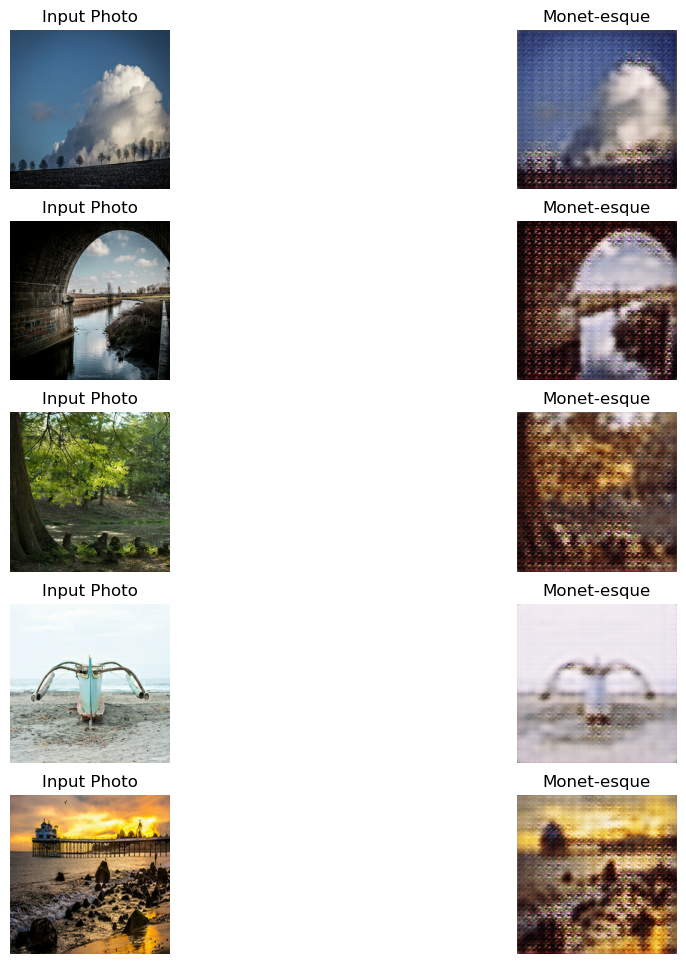

In [46]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Image Comparison

As can be seen in the samples above, the model provides a reasonable representation of the photographs in the Monet style.  However, the representations are quite grainy and unclear.  The smoothness that is apparent in the Monet style is clearly not represented by the reproductions.  Given the processing time required (lack of GPU acceleration on local machine) these representations are based on 5 epochs. 


### Conclusion

Various models were trained and tested utilizing two different optimizers (Adam and SGD) over four epoch counts (5, 10, 15, 20).  As can be seen in Table 1, the Adam optimizer provided superior performance.  Increasing epoch count also led the model to increased performance.  The SGD model seemd to begin to overshoot at 20 epochs leading one to believe that as the momentum increased the model began to spin out of control.  The fairly consistent discriminator loss and indicates that as the momentum increased the discrimonimator gained the ability to fool the generator.

Through the course of model development and testing batch size, SGD learning rate and SGD momentum were varied to assess the impact on the model's performance and resource consumption.  Batch sizes were varied from (4,4) to 8 and to 2.  Interestingly enough the (4,4) configuration provided the most expedient processing.  Changing the batch size to 8 or 2 slowed the processing dramatically.

For comparison purposes, the Adam optimization parameters were left defaulted to the tutorial values.  Only the SGD parameters were varied.  In the intial trial the learning rate was set to .025 and the momentum to .05.  This vlaues were clearly too large and the model produce NaN and infinte loss values.  It took walking both values down to .0001 to produce useable results.  Even then, based on the deteriorating results at 20 epochs, these values still appear to be too large.  Further work is required to determine if a different combination of SGD parameters would provide comparable performance to the Adam optimizer.

**Submission**

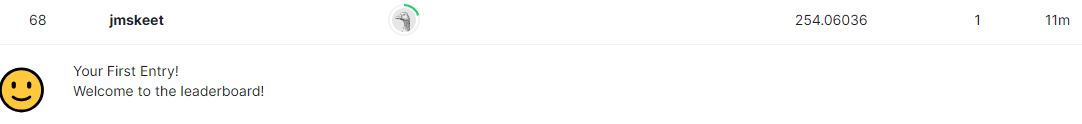

### References

GAN — CycleGAN (Playing magic with pictures), https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7

Monet CycleGAN Tutorial, https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

Train your first CycleGAN for Image to Image Translation, https://blog.jaysinha.me/train-your-first-cyclegan-for-image-to-image-translation/

Overview of CycleGAN architecture and training, https://towardsdatascience.com/overview-of-cyclegan-architecture-and-training-afee31612a2f#:~:text=A%20CycleGAN%20is%20composed%20of,other%20transform%20zebras%20into%20horses.

Tensorflow CycleGan, https://www.tensorflow.org/tutorials/generative/cyclegan

A hands-on guide to TFRecords, https://towardsdatascience.com/a-practical-guide-to-tfrecords-584536bc786c

### Kaggle Code Refernces
CycleGAN Monet, https://www.kaggle.com/code/anubhav012/cyclegan-monet